In [ ]:
%tensorflow_version 2.x # selecting tensorflow version

!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;
!sudo pip install efficientnet;

---

## Στοιχεία Ομάδας

Αριθμός Ομάδας F05

  > Καρυπιάδης Ευστράτιος: 03114911
  
  > Σταματελόπουλος Νικόλαος: 03116138

---

## Σύνολο Δεδομένων CIFAR-100

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

### Εισαγωγή συνόλου δεδομένων

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, utils
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

Για τους σκοπούς της άσκησης **δε** θα εκμεταλλευτούμε ολόκληρο το σύνολο δεδομένων, αλλά θα δουλέψουμε σε ένα υποσύνολο αυτού σύμφώνα με τον αύξοντα αριθμό της ομάδας μας, `team_seed`. Στη συνέχεια υλοποιούμε μία σειρά βοηθητικών συναρτήσεων που θα μας βοηθήσουν σε αυτόν το διαχωρισμό:

In [5]:
def select_from_list(from_list, index_list):
  """ Return from_list elemenents according to index contained in index_list. """
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

def get_ds_index(unfiliterd_list, target_list):
  """ Append in filtered_list the index of each element in unfiltered_list if it exists in target_list. """
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def select_classes_number(classes_number=20):
  """ Select unique subset of CIFAR-100 with classes_number of classes. """
  if classes_number == 20:
    return "https://bit.ly/3b3Cewb"
  elif classes_number == 40:
    return "https://bit.ly/3aPo819"
  elif classes_number == 60:
    return "https://bit.ly/2Wbo47K"
  elif classes_number == 80:
    return "https://bit.ly/38NDW3d"
  else:
    return -1

### Διαχωρισμός δεδομένων εκπαίδευσης - ελέγχου

Στο επόμενο κελί επιλέγουμε το πλήθος των κατηγοριών με το οποίο επιθυμούμε να δουλέψουμε:

In [6]:
cifar100_classes_url = select_classes_number(classes_number=80) # default: 20 classes

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [7]:
team_seed = 5 # team_seed number

team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None) # fetch class indexes
CIFAR100_LABELS_LIST = pd.read_csv("https://bit.ly/3cRO3qZ", sep=',', header=None).astype(str).values.tolist()[0] # fetch class names

our_index = team_classes.iloc[team_seed, :].values.tolist() # select team class indices
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index) # select team class names

train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

# Train data and labels
x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))

# Test data and labels
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

Μετά την παραπάνω διαδικασία εμφανίζουμε τα ονόματα των κατηγοριών που αντιστοιχούν στην ομάδα μας:

In [8]:
print(our_classes)

[' aquarium_fish', ' baby', ' bear', ' beaver', ' bee', ' bicycle', ' bottle', ' bowl', ' boy', ' bus', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' clock', ' cloud', ' cockroach', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' orange', ' orchid', ' otter', ' palm_tree', ' pickup_truck', ' pine_tree', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' skunk', ' skyscraper', ' snail', ' snake', ' squirrel', ' streetcar', ' sunflower', ' table', ' tank', ' television', ' tractor', ' train', ' trout', ' tulip', ' turtle', ' wardrobe', ' whale', ' wolf', ' worm']


### Επισκόπηση δεδομένων και κανονικοποίηση

Τέλος, για καλύτερη εποπτεία του συνόλου δεδομένων μας θα εξάγουμε ορισμένες χρήσιμες πληροφορίες για αυτό, ενώ παράλληλα θα κανονικοποιήσουμε τις τιμές αναπαράστασης των εικόνων:

In [9]:
data_size, img_rows, img_cols, img_channels = x_train_ds.shape # get train dataset dimensions

# Set validation set percentage
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# Summarize loaded dataset
print('Train:       X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation:  X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test:        X=%s, y=%s' % (x_test.shape, y_test.shape))

Train:       X=(34000, 32, 32, 3), y=(34000, 1)
Validation:  X=(6000, 32, 32, 3), y=(6000, 1)
Test:        X=(8000, 32, 32, 3), y=(8000, 1)


---

## Συναρτήσεις Προετοιμασίας Δεδομένων και Οπτικοποίησης Απόδοσης

Στη συνέχεια θα υλοποιήσουμε απαραίτητες συναρτήσεις προετοιμασίας των δεδομένων για εκπαίδευση, καθώς και οπτικοποίσης της τελικής απόδοσης των μοντέλων που πρόκειται να δοκιμάσουμε.

### Συναρτήσεις εκπαίδευσης

Αρχικά θα υλοποιήσουμε την `_input_fn`, η οποία αποτελεί ένα *pipeline* που θα προετοιμάσει τα δεδομένα μας για την εκπαίδευση. Πιο συγκεκριμένα, χρησιμοποιούμε τις μεθόδους `shuffle`, `repeat` και `batch` της [tf.data.Dataset](https://bit.ly/2vk7EPr), ώστε να δημιουργήσουμε υποσύνολα 64 δειγμάτων, τα οποία ελήφθησαν τυχαίως από το ολικό μας σύνολο. Παρατηρούμε ότι η μέθοδος `repeat` είναι απαραίτητη για να αντιμετωπίσουμε τυχόν σφάλμα που θα προκύψει, εάν η μέθοδος `batch` επιχειρήσει να δημιουργήσει εκ νέου υποσύνολο, αφού έχει ομαδοποιήσει όλα τα διαθέσιμα δείγματα του συνόλου. 

Σημειώνουμε ότι η συνάρτηση επιστρέφει υποσύνολα δεδομένων `PrefetchDataset Objects`, μορφή η οποία επιταχύνει τη διαδικασία εκπαίδευσης, καθώς επιτρέπει το διάβασμα του επόμενου batch δεδομένων, ενώ παράλληλα εκπαιδεύεται το παρόν.

In [10]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def _input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE)
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

Στη συνέχεια υλοποιούμε τη συνάρτηση `train_model`. Σημειώνουμε ότι με την παράμετρο `steps_per_epoch` μπορούμε να επιλέξουμε το πλήθος των *batches* στο οποίο επιθυμούμε να εκπαιδευτεί το μοντέλο μας πριν περάσει στην επόμενη εποχή.

In [11]:
def train_model(model, epochs):
  """ Training function. """
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=x_train.shape[0]//BATCH_SIZE, validation_data=validation_ds, validation_steps=x_val.shape[0]//BATCH_SIZE)
  return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

Τέλος, υλοποιούμε συναρτήσεις οπτικοποίησης της απόδοσης της εκπαίδευσης προς εξαγωγή χρήσιμων πληροφοριών και μελέτη των αποτελεσμάτων που θα προκύψουν από τη δοκιμή των μοντέλων μας.

In [12]:
def summarize_diagnostics(history):
	""" Plot diagnostic learning curves. """
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='Train')
	plt.plot(history.history['val_accuracy'], color='orange', label='Validation')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()
 
def model_evaluation(model, evaluation_steps):
	""" Print test set and evaluation metrics. """
	print('\nTest set evaluation metrics')
	loss0, accuracy0 = model.evaluate(test_ds, steps=x_test.shape[0]//BATCH_SIZE)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps=10):
	summarize_diagnostics(history)
	model_evaluation(model, evaluation_steps)
 
def summarize_all_diagnostics(m1, m2, m3, m4, m5):
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	plt.plot(m1['accuracy'], color='red', linestyle='-', label='Softmax')
	plt.plot(m1['val_accuracy'], color='red', linestyle='--')
	plt.plot(m2['accuracy'], color='blue', linestyle='-', label='MLP')
	plt.plot(m2['val_accuracy'], color='blue', linestyle='--')
	plt.plot(m3['accuracy'], color='green', linestyle='-', label='LeNet')
	plt.plot(m3['val_accuracy'], color='green', linestyle='--')
	plt.plot(m4['accuracy'], color='orange', linestyle='-', label='CNN1')
	plt.plot(m4['val_accuracy'], color='orange', linestyle='--')
	plt.plot(m5['accuracy'], color='magenta', linestyle='-', label='CNN2')
	plt.plot(m5['val_accuracy'], color='magenta', linestyle='--')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()

---

## Ερώτημα 1: Μοντέλα Δικτύων

In [13]:
import json # for saving training history

Στη συνέχεια καλούμαστε να υλοποιήσουμε 5 διαφορετικές αρχιτεκτονικές συνελικτικών δικτύων. Για κάθε μία από αυτές θα πρέπει να επιλέξουμε δύο βέλτιστους συνδυασμούς optimizer, loss function, metrics και epoch.

- Σχετικά με τους [optimizers](https://keras.io/api/optimizers/) δοκιμάσαμε σε όλες τις αρχιτεκτονικές τους [Adam](https://keras.io/api/optimizers/adam/), [Nadam](https://keras.io/api/optimizers/Nadam/), [Adamax](https://keras.io/api/optimizers/adamax/), [Adagrad](https://keras.io/api/optimizers/adagrad/), [Adadelta](https://keras.io/api/optimizers/adadelta/), [RMSProp](https://keras.io/api/optimizers/rmsprop/) και [Stochastic Gradient Descent](https://keras.io/api/optimizers/sgd/). Επιλέξαμε δύο από αυτούς σε κάθε δίκτυο, ανάλογα με την απόδοσή τους. Αξίζει να σημειώσουμε ότι σε κάθε optimizer, πειραματιστήκαμε και με το ρυθμό μάθησης, για να αποφανθούμε για την επίδοσή του.

- Μελετώντας το API του Keras, παρατηρούμε ότι η μοναδική [loss function](https://keras.io/api/losses/) που εξυπηρετεί την επίλυση του προβλήματός μας είναι η [Categorical Cross Entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Καταλήγουμε σε αυτήν την επιλογή, αγνοώντας αφενός τα regression losses, καθώς δεν εφάπτονται της ταξινόμησης εικόνων που επιχειρούμε και αφετέρου τις συναρτήσεις Kullback-Leibler Divergence και Hinge. Σχετικά με τις δύο τελευταίες, παρατηρούμε ότι μέσα από πειραματισμούς μας δε φαίνεται να συγκλίνουν σε ελάχιστη τιμή, ενώ παράλληλα δίνουν χαμηλές τιμές απόδοσης στα metrics που δοκιμάσαμε. Επίσης σημειώνουμε ότι οι συγκεκριμένες συναρτήσεις συνηθίζεται να χρησιμοποιούνται σε διαφορετικού τύπου εφαρμογές, όπως για παράδειγμα στους Autoencoders.

- Βασική μας [metric](https://keras.io/api/metrics/) συνάρτηση είναι η [ακρίβεια ταξινόμησης](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class), πάνω στην οποία θα στηριχτούμε προκειμένου να αποφανθούμε για την απόδοση των δικτύων μας.

- Τέλος, σημειώνουμε ότι κατά τη διαδικασία δοκιμών των παραπάνω παραμέτρων, εκπαιδεύσαμε πειραματικά κάθε δίκτυο για διάρκεια 10 εποχών. Σύμφωνα με τα αποτελέσματα που συλλέξαμε, επιλέξαμε για την εκάστοτε αρχιτεκτονική τους 2 καλύτερους συνδυασμούς, τους οποίους χρησιμοποιήσαμε για την ολοκληρωμένη εκπαίδευση, διάρκειας τουλάχιστον 50 εποχών, των τελικών 10 δικτύων μας.

### Softmax

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρώντας το διάγραμμα απόδοσης που ακολουθεί, οι 50 `epochs` είναι αρκετές για την εκπαίδευση του μοντέλου, δεδομένου ότι δεν παρουσιάζεται τάση ανόδου για την απόδοση του δικτύου στα δεδομένα επαλήθευσης.

In [ ]:
def init_softmax_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAM = init_softmax_adam(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAM_history = train_model(SOFTMAX_MODEL_ADAM, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAM_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAM.json', 'w'))

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_41 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 2s 4ms/step - loss: 4.1378 - accuracy: 0.0693 - val_loss: 3.9297 - val_accuracy: 0.0985
Epoch 2/50
531/531 [==============================] - 2s 4ms/step - loss: 3.8280 - accuracy: 0.1216 - val_loss: 3.7978 - val_accuracy: 0.1263
Epoch 3/50
531/531 [==============================] - 2s 4ms/step - loss: 3.7180 - accuracy: 0.1426 - val_loss: 3.7267 - val_accuracy: 0.1381
Epoch 4/50
531/531 [==============================] - 2s 4ms/step - loss: 3.6505 - 

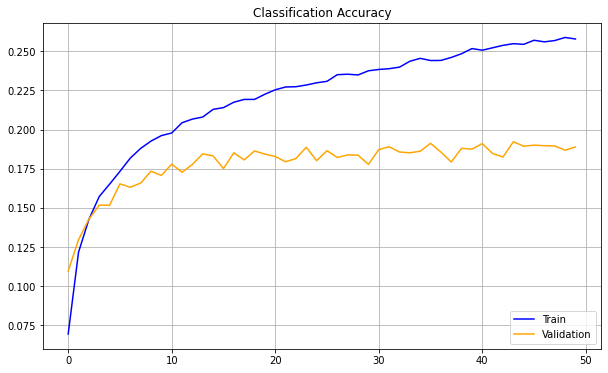


Test set evaluation metrics
125/125 [==============================] - 0s 3ms/step - loss: 3.4922 - accuracy: 0.1974
loss: 3.49
accuracy: 0.20


In [ ]:
model_report(SOFTMAX_MODEL_ADAM, SOFTMAX_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε και εδώ τις 50 `epochs` εκπαίδευσης.

In [ ]:
def init_softmax_adagrad(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD = init_softmax_adagrad(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAGRAD_history = train_model(SOFTMAX_MODEL_ADAGRAD, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 2s 4ms/step - loss: 4.0613 - accuracy: 0.0763 - val_loss: 3.8475 - val_accuracy: 0.1025
Epoch 2/50
531/531 [==============================] - 2s 4ms/step - loss: 3.7375 - accuracy: 0.1305 - val_loss: 3.7328 - val_accuracy: 0.1327
Epoch 3/50
531/531 [==============================] - 2s 4ms/step - loss: 3.6341 - accuracy: 0.1583 - val_loss: 3.6607 - val_accuracy: 0.1460
Epoch 4/50
531/531 [==============================] - 2s 4ms/step - loss: 3.5729 - a

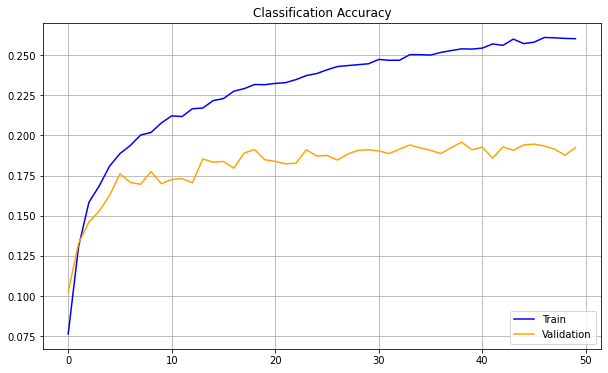


Test set evaluation metrics
125/125 [==============================] - 0s 3ms/step - loss: 3.4759 - accuracy: 0.1992
loss: 3.48
accuracy: 0.20


In [ ]:
model_report(SOFTMAX_MODEL_ADAGRAD, SOFTMAX_MODEL_ADAGRAD_history)

### MLP

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Nadam` με `lr=0.0001`. Εδώ επιλέγουμε 75 `epochs` εκπαίδευσης παρατηρώντας την ανοδική τάσης της ακρίβειας του δικτύου στα δεδομένα επαλήθευσης που κυριαρχούσε στις 50 εποχές.

In [ ]:
def init_mlp_nadam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Nadam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_NADAM = init_mlp_nadam(summary=True)

# Train for 75 epochs
MLP_MODEL_NADAM_history = train_model(MLP_MODEL_NADAM, 75)

# Dump training history
history_dict = MLP_MODEL_NADAM_history.history
json.dump(history_dict, open('MLP_MODEL_NADAM.json', 'w'))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_29 (Dense)             (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 5s 10ms/step - loss: 4.0657 - accuracy: 0.0831 - val_loss: 3.7897 - val_accuracy: 0.1287
Epoch 2/75
531/531 [==============================] - 5s 8ms/step - loss: 3.6908 - accuracy: 0.1392 - val_loss: 3.6820 - val_accuracy: 0.1396
Epoch 3/75
531/531 [==============================] - 4s 8ms/step - loss: 3.5506 - accur

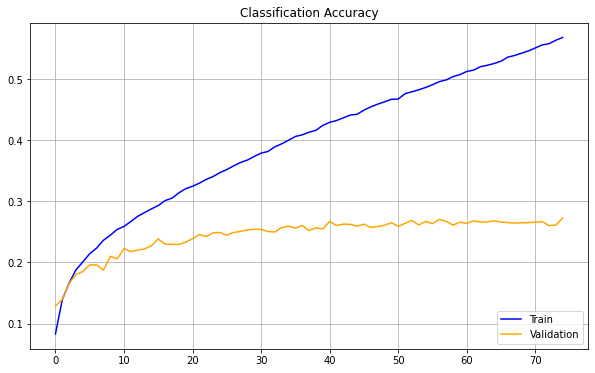


Test set evaluation metrics
125/125 [==============================] - 0s 3ms/step - loss: 3.1794 - accuracy: 0.2756
loss: 3.18
accuracy: 0.28


In [ ]:
model_report(MLP_MODEL_NADAM, MLP_MODEL_NADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε τις 75 `epochs` εκπαίδευσης.

In [ ]:
def init_mlp_adagrad(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAGRAD = init_mlp_adagrad(summary=True)

# Train for 100 epochs
MLP_MODEL_ADAGRAD_history = train_model(MLP_MODEL_ADAGRAD, 75)

# Dump training history
history_dict = MLP_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('MLP_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_33 (Dense)             (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 3s 6ms/step - loss: 4.0716 - accuracy: 0.0736 - val_loss: 3.7875 - val_accuracy: 0.1216
Epoch 2/75
531/531 [==============================] - 3s 6ms/step - loss: 3.6965 - accuracy: 0.1327 - val_loss: 3.6308 - val_accuracy: 0.1547
Epoch 3/75
531/531 [==============================] - 3s 6ms/step - loss: 3.5481 - accura

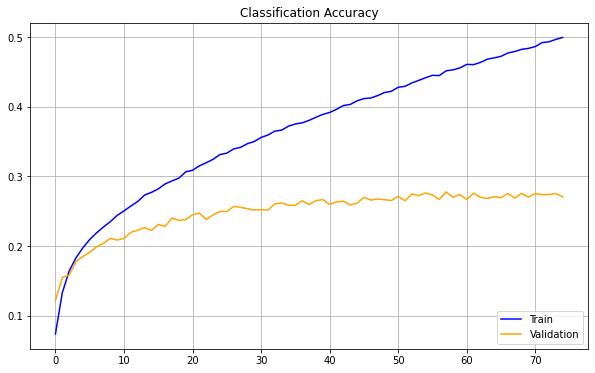


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.0460 - accuracy: 0.2839
loss: 3.05
accuracy: 0.28


In [ ]:
model_report(MLP_MODEL_ADAGRAD, MLP_MODEL_ADAGRAD_history)

### LeNet

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Ακολουθώντας το ίδιο σκεπτικό με παραπάνω, επιλέγουμε 100 `epochs` εκπαίδευσης.

In [ ]:
def init_lenet_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAM = init_lenet_adam(summary=True)

# Train for 100 epochs
LENET_MODEL_ADAM_history = train_model(LENET_MODEL_ADAM, 100)

# Dump training history
history_dict = LENET_MODEL_ADAM_history.history
json.dump(history_dict, open('LENET_MODEL_ADAM.json', 'w'))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_49 (Dense)             (None, 200)             

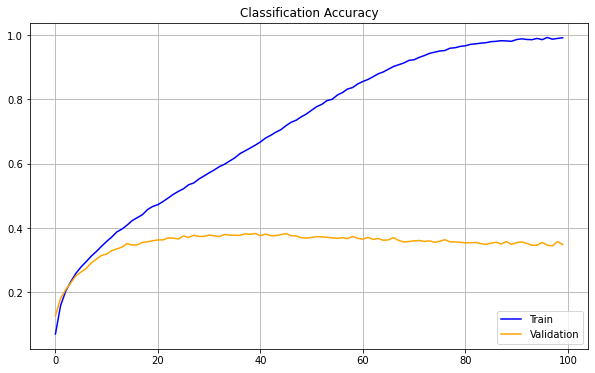


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 5.7183 - accuracy: 0.3679
loss: 5.72
accuracy: 0.37


In [ ]:
model_report(LENET_MODEL_ADAM, LENET_MODEL_ADAM_history)

Το δεύτερο μοντέλο έχει `Adamax` optimizer με `lr=0.01`. Διατηρούμε τις 100 `epochs` εκπαίδευσης.

In [ ]:
def init_lenet_adamax(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAMAX = init_lenet_adamax(summary=True)

# Train for 100 epochs
LENET_MODEL_ADAMAX_history = train_model(LENET_MODEL_ADAMAX, 100)

# Dump training history
history_dict = LENET_MODEL_ADAMAX_history.history
json.dump(history_dict, open('LENET_MODEL_ADAMAX.json', 'w'))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_51 (Dense)             (None, 200)             

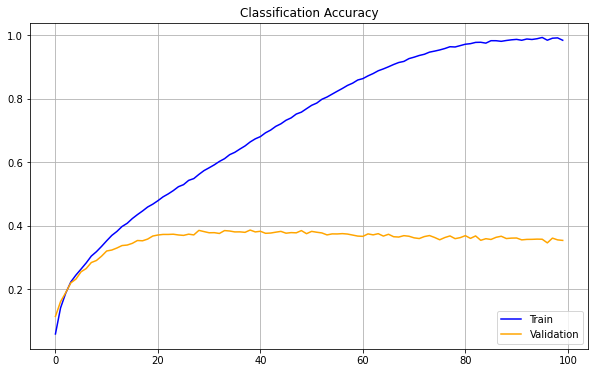


Test set evaluation metrics
125/125 [==============================] - 1s 4ms/step - loss: 6.0467 - accuracy: 0.3555
loss: 6.05
accuracy: 0.36


In [ ]:
model_report(LENET_MODEL_ADAMAX, LENET_MODEL_ADAMAX_history)

### CNN1

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Ακολουθώντας το ίδιο σκεπτικό με παραπάνω, επιλέγουμε 100 `epochs` εκπαίδευσης.

In [ ]:
def init_cnn1_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_ADAM = init_cnn1_adam(summary=True)

# Train for 100 epochs
CNN1_MODEL_ADAM_history = train_model(CNN1_MODEL_ADAM, 100)

# Dump training history
history_dict = CNN1_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN1_MODEL_ADAM.json', 'w'))

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten_30 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 200)             

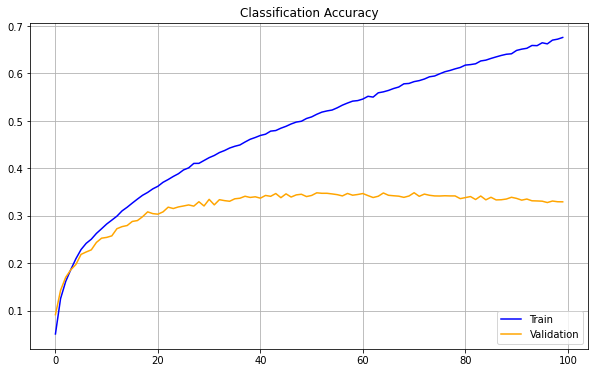


Test set evaluation metrics
125/125 [==============================] - 1s 4ms/step - loss: 3.2578 - accuracy: 0.3421
loss: 3.26
accuracy: 0.34


In [ ]:
model_report(CNN1_MODEL_ADAM, CNN1_MODEL_ADAM_history)

Το δεύτερο μοντέλο έχει `SGD` optimizer με `lr=0.01`. Διατηρούμε τις 100 `epochs` εκπαίδευσης.

In [ ]:
def init_cnn1_sgd(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.SGD(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_SGD = init_cnn1_sgd(summary=True)

# Train for 100 epochs
CNN1_MODEL_SGD_history = train_model(CNN1_MODEL_SGD, 100)

# Dump training history
history_dict = CNN1_MODEL_SGD_history.history
json.dump(history_dict, open('CNN1_MODEL_SGD.json', 'w'))

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten_31 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 200)             

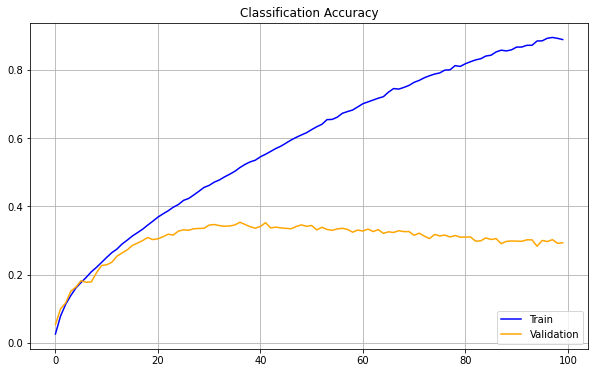


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 7.7285 - accuracy: 0.3100
loss: 7.73
accuracy: 0.31


In [ ]:
model_report(CNN1_MODEL_SGD, CNN1_MODEL_SGD_history)

### CNN2

Η αρχιτεκτονική του δικτύου μας είναι επηρεασμένη από εκείνη του VGG16. Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρούμε ότι οι 50 `epochs` εκπαίδευσης είναι αρκετές για το μοντέλο μας.

In [ ]:
def init_CNN2_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAM = init_CNN2_adam(summary=True)

# Train for 50 epochs
CNN2_MODEL_ADAM_history = train_model(CNN2_MODEL_ADAM, 50)

# Dump training history
history_dict = CNN2_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAM.json', 'w'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 512)        

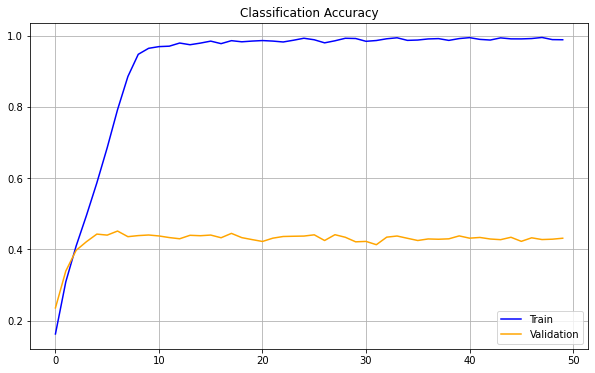


Test set evaluation metrics
125/125 [==============================] - 2s 12ms/step - loss: 5.5783 - accuracy: 0.4509
loss: 5.58
accuracy: 0.45


In [ ]:
model_report(CNN2_MODEL_ADAM, CNN2_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε σταθερή τη διάρκεια εκπαίδευσης στις 50 `epochs`.

In [ ]:
def init_CNN2_adagrad(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAGRAD = init_CNN2_adagrad(summary=True)

# Train for 50 epochs
CNN2_MODEL_ADAGRAD_history = train_model(CNN2_MODEL_ADAGRAD, 50)

# Dump training history
history_dict = CNN2_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 512)        

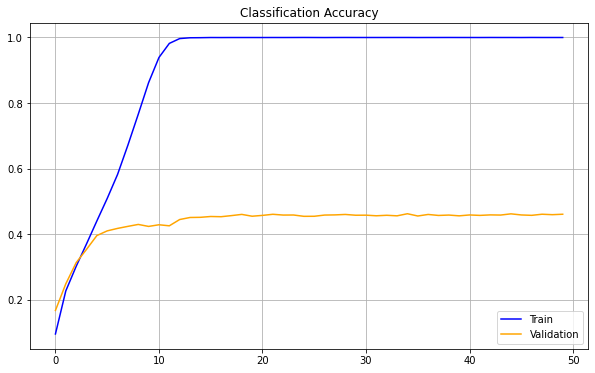


Test set evaluation metrics
125/125 [==============================] - 1s 12ms/step - loss: 4.1908 - accuracy: 0.4591
loss: 4.19
accuracy: 0.46


In [ ]:
model_report(CNN2_MODEL_ADAGRAD, CNN2_MODEL_ADAGRAD_history)

### Αξιολόγηση Μοντέλων

In [ ]:
# Reload best history according to accuracy-loss
m1 = json.load(open('SOFTMAX_MODEL_ADAGRAD.json', 'r'))
m2 = json.load(open('MLP_MODEL_ADAGRAD.json', 'r'))
m3 = json.load(open('LENET_MODEL_ADAM.json', 'r'))
m4 = json.load(open('CNN1_MODEL_ADAM.json', 'r'))
m5 = json.load(open('CNN2_MODEL_ADAGRAD.json', 'r'))

Παρακάτω παρουσιάζεται ένα συνολικό διάγραμμα των καλύτερων μοντέλων των παραπάνω αρχιτεκτονικών. Με συνεχόμενη γραμμή απεικονίζουμε την καμπύλη ακριβείας στα δεδομένα εκπαίδευσης, ενώ με διακεκομμένη την καμπύλη ακριβείας στα δεδομένα επαλήθευσης.

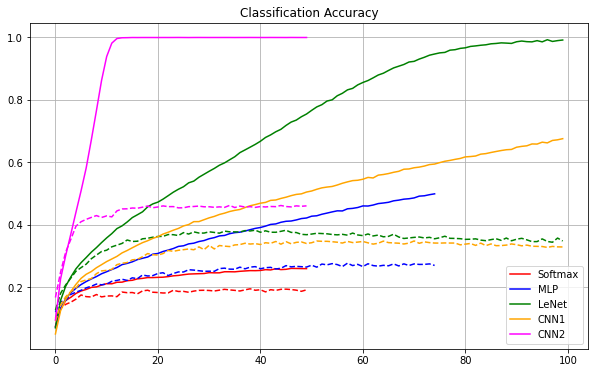

In [ ]:
summarize_all_diagnostics(m1, m2, m3, m4, m5)

---

## Ερώτημα 2: Αντιμετώπιση Υπερεκπαίδευσης

Μελετώντας τα διάγραμματα των παραπάνω αρχιτεκτονικών παρατηρούμε μία έντονη διαφορά μεταξύ των καμπυλών ακρίβειας στα δεδομένα εκπαίδευσης και επαλήθευσης. Αυτή η διαφορά υποδεικνύει το πρόβλημα του overfitting στα δεδομένα εκπαίδευσης, το οποίο θα επιχειρήσουμε να αντιμετωπίσουμε με τις παρακάτω τρεις τεχνικές:

- Θα εφαμόσουμε την τεχνική του `tf.keras.callbacks.EarlyStopping`, κατά την οποία η εκπαίδευση θα διακόπτεται έαν δεν υφίσταται βελτίωση στη μείωση του σφάλματος για περισσότερο από n κύκλους εκπαίδευσης. Επιλέγουμε `patience=10`.

- Θα προσθέσουμε στις αρχιτεκτονικές των δικτύων μας `tf.keras.layers.Dropout` layers.

- Τέλος, θα εκμεταλλευτούμε [ImageDataGenerator](https://bit.ly/33B1reJ), για να εφαρμόσουμε data augmentation στα δεδομένα εκπαίδευσης. Επιλέγουμε να χρησιμοποιήσουμε τους μετασχηματισμούς `rotation_range`, `width_shift_range`, `height_shift_range` και `horizontal_flip`.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialization of EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

### Softmax

In [20]:
def init_softmax_adagrad_opt(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD_OPT = init_softmax_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
SOFTMAX_MODEL_ADAGRAD_OPT_history = SOFTMAX_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
SOFTMAX_MODEL_ADAGRAD_OPT.save('SOFTMAX_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_OPT_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD_OPT.json', 'w'))

In [ ]:
model_report(SOFTMAX_MODEL_ADAGRAD_OPT, SOFTMAX_MODEL_ADAGRAD_OPT_history)

### MLP

In [22]:
def init_mlp_adagrad_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAGRAD_OPT = init_mlp_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
MLP_MODEL_ADAGRAD_OPT_history = MLP_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
MLP_MODEL_ADAGRAD_OPT.save('MLP_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = MLP_MODEL_ADAGRAD_OPT_history.history
json.dump(history_dict, open('MLP_MODEL_ADAGRAD_OPT.json', 'w'))

In [ ]:
model_report(MLP_MODEL_ADAGRAD_OPT, MLP_MODEL_ADAGRAD_OPT_history)

### LeNet

In [ ]:
def init_lenet_adam_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAM_OPT = init_lenet_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
LENET_MODEL_ADAM_OPT_history = LENET_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
LENET_MODEL_ADAM_OPT.save('LENET_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = LENET_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('LENET_MODEL_ADAM_OPT.json', 'w'))

In [ ]:
model_report(LENET_MODEL_ADAM_OPT, LENET_MODEL_ADAM_OPT_history)

### CNN1

In [ ]:
def init_cnn1_adam_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Dropout(0.50))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_ADAM_OPT = init_cnn1_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
CNN1_MODEL_ADAM_OPT_history = CNN1_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
CNN1_MODEL_ADAM_OPT.save('CNN1_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = CNN1_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('CNN1_MODEL_ADAM_OPT.json', 'w'))

In [ ]:
model_report(CNN1_MODEL_ADAM_OPT, CNN1_MODEL_ADAM_OPT_history)

### CNN2

In [ ]:
def init_CNN2_adagrad_opt(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.10))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.50))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAGRAD_OPT = init_CNN2_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
CNN2_MODEL_ADAGRAD_OPT_history = CNN2_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
CNN2_MODEL_ADAGRAD_OPT.save('CNN2_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = CNN2_MODEL_ADAGRAD_OPT.history
json.dump(history_dict, open('CNN2_MODEL_ADAGRAD_OPT.json', 'w'))

In [ ]:
model_report(CNN2_MODEL_ADAGRAD_OPT, CNN2_MODEL_ADAGRAD_OPT_history)

---

## Ερώτημα 3: Transfer Learning